# Variance Comparisons

The following codes generate the figures shown in my lab seminar presentation.

In [93]:
library(dplyr)
library(rstan)
library(ggplot2)
library(gridExtra)
library(xtable)

options(repr.plot.width = 10, repr.plot.height = 7)

source("bbvi_simplemix.R")

## Variance Comparisons Between Naive, Rao-Blackwellized, and James-Stein Estimators

We will be performing the estimation repeatedly, to get a controlled Monte Carlo sample of the inherent variances in the estimators being compared.

**Don't Run The Next Cell Unless Updating Results**

In [16]:
all.variances <- NULL
niter <- 300
sampsize <- 150
mc_size <- 1000

all_means <- -5:5

for(K in 2:6){
    d <- generate_mixture(sampsize, runif(K), means=all_means[1:K])

    phi <- t(sapply(d, function(x){
        y <- runif(K)
        return(y/sum(y))
    }))

    m <- all_means[1:K] + 1
    iters <- list(niter)
    for(i in 1:niter){
        if(i %% 50 == 0) message(paste0("Mixture Components: ", K, "; Iteration: ", i, "/", niter))
        
        dat.nav <- generate_samples(mc_size, y = d, phi = phi, m=m, method="Naive")
        dat.rbl <- generate_samples(mc_size, y = d, phi = phi, m=m, method="RB")
        dat.jsp <- generate_samples(mc_size, y = d, phi = phi, m=m, method="JS+")
        dat.rbp <- generate_samples(mc_size, y = d, phi = phi, m=m, method="RB+")

        iters[[i]] <- rbind(
            cbind(method="Naive", iter=i, generate_bbvi(dat.nav)),
            cbind(method="RB", iter=i, generate_bbvi(dat.rbl)),
            cbind(method="JS+", iter=i, generate_bbvi(dat.jsp)),
            cbind(method="RB+", iter=i, generate_bbvi(dat.rbp))
        )
    }

    mse <- do.call('rbind',iters)
    par.variances <- aggregate(mse[,4:ncol(mse)], by=list(method=mse$method, param=mse$param), var)
    for(method in c("Naive","RB","JS+","RB+")){
        this.method <- par.variances[par.variances$method == method,3:ncol(par.variances)]
        all.variances <- rbind(all.variances,
            data.frame(K=K, method=method,logVar=log(mean(as.matrix(this.method)))))
    }
}

saveRDS(all.variances, "Outputs/all_variances_2_6_version2.R")
saveRDS(mse, "Outputs/last_iteration.R")

Mixture Components: 2; Iteration: 50/300

Mixture Components: 2; Iteration: 100/300

Mixture Components: 2; Iteration: 150/300

Mixture Components: 2; Iteration: 200/300

Mixture Components: 2; Iteration: 250/300

Mixture Components: 2; Iteration: 300/300

Mixture Components: 3; Iteration: 50/300

Mixture Components: 3; Iteration: 100/300

Mixture Components: 3; Iteration: 150/300

Mixture Components: 3; Iteration: 200/300

Mixture Components: 3; Iteration: 250/300

Mixture Components: 3; Iteration: 300/300

Mixture Components: 4; Iteration: 50/300

Mixture Components: 4; Iteration: 100/300

Mixture Components: 4; Iteration: 150/300

Mixture Components: 4; Iteration: 200/300

Mixture Components: 4; Iteration: 250/300

Mixture Components: 4; Iteration: 300/300

Mixture Components: 5; Iteration: 50/300

Mixture Components: 5; Iteration: 100/300

Mixture Components: 5; Iteration: 150/300

Mixture Components: 5; Iteration: 200/300

Mixture Components: 5; Iteration: 250/300

Mixture Compone

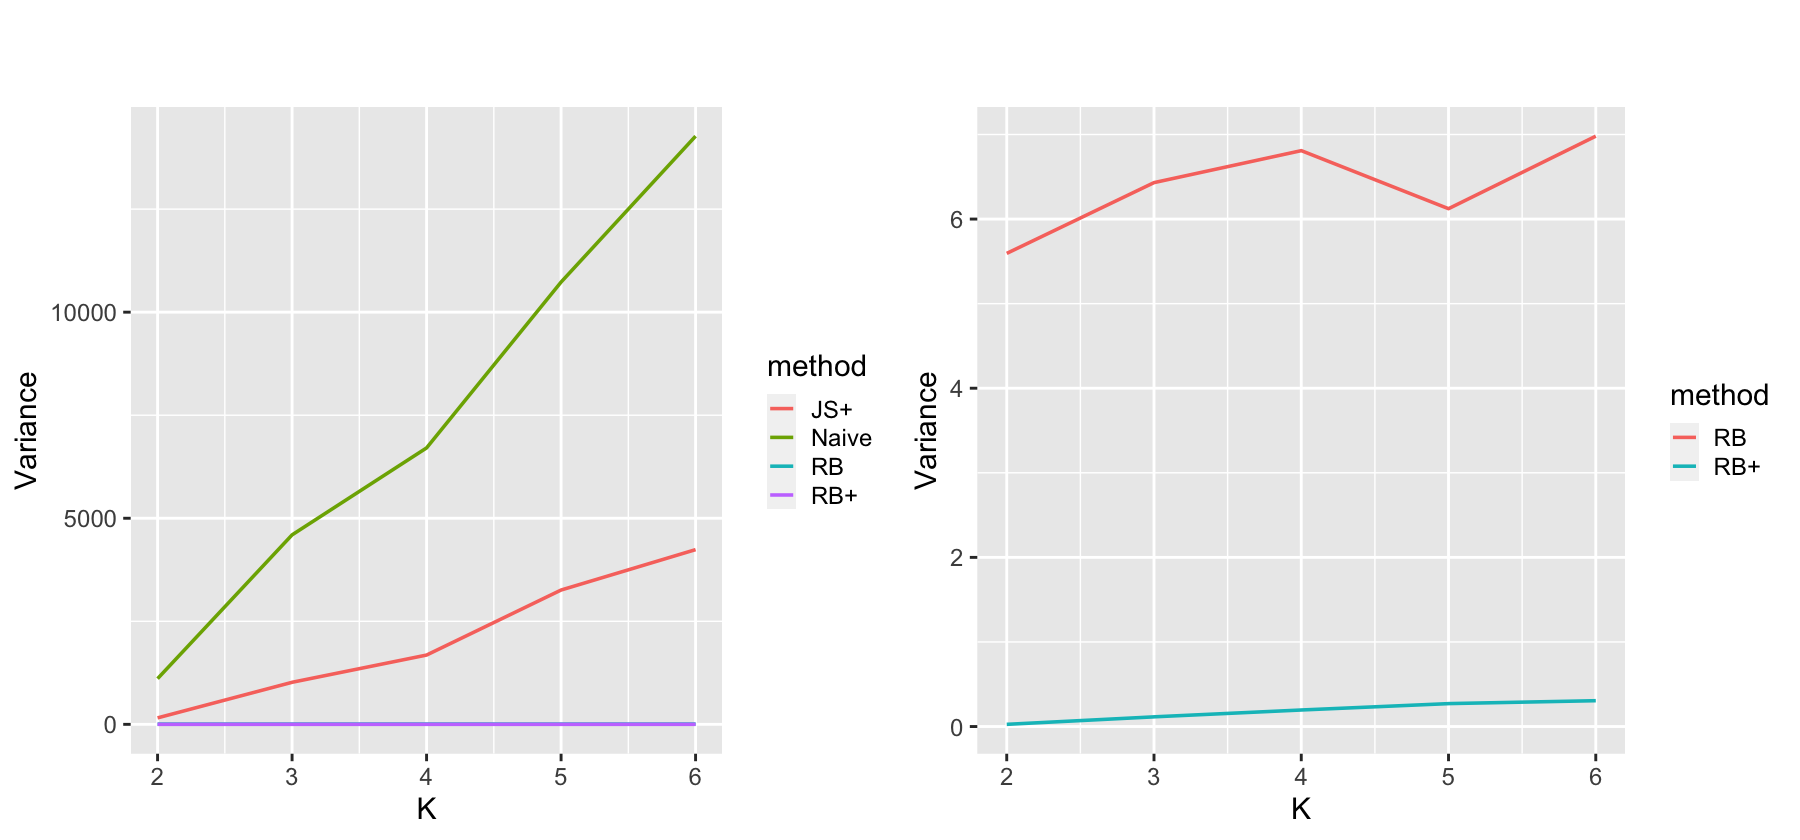

In [69]:
all.variances <- rbind(
    readRDS("Outputs/all_variances_2_6_version2.R"),
    readRDS("Outputs/all_variances_7_10.R")
)

all.variances <- readRDS("Outputs/all_variances_2_6_version2.R")

p1 <- all.variances %>%
    ggplot(aes(x=K, y=exp(logVar), color=method)) +
    geom_line(linewidth=1) + 
    labs(title = "", subtitle = "", x = "K", y = "Variance") +
    theme_grey(base_size=18)
p2 <- all.variances %>%
    filter(method %in% c("RB","RB+")) %>%
    ggplot(aes(x=K, y=exp(logVar), color=method)) +
    geom_line(linewidth=1) + 
    labs(title = "", subtitle = "", x = "K", y = "Variance") +
    theme_grey(base_size=18)

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, nrow = 1)

In [95]:
all.efficiencies <- NULL
for(k in 2:6){
    this.var <- all.variances[all.variances$K == k, ]
    this.var$Var <- exp(this.var$logVar)
    this.var$Eff <- 1
    this.var$Eff[2:4] <- 100 * this.var$Var[2:4]/this.var$Var[1]
    all.efficiencies <- rbind(all.efficiencies, this.var)
}

table <- all.efficiencies %>%
    filter(K %in% c(2,4,6)) %>%
    mutate(Var = round(Var, 2)) %>%
    select(K, method, Var, Eff)

print(xtable(table))

% latex table generated in R 4.2.3 by xtable 1.8-4 package
% Wed Apr 24 14:46:19 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrlrr}
  \hline
 & K & method & Var & Eff \\ 
  \hline
1 &   2 & Naive & 1108.37 & 1.00 \\ 
  2 &   2 & RB & 5.59 & 0.50 \\ 
  3 &   2 & JS+ & 156.70 & 14.14 \\ 
  4 &   2 & RB+ & 0.03 & 0.00 \\ 
  5 &   4 & Naive & 6706.56 & 1.00 \\ 
  6 &   4 & RB & 6.81 & 0.10 \\ 
  7 &   4 & JS+ & 1680.87 & 25.06 \\ 
  8 &   4 & RB+ & 0.20 & 0.00 \\ 
  9 &   6 & Naive & 14270.40 & 1.00 \\ 
  10 &   6 & RB & 6.98 & 0.05 \\ 
  11 &   6 & JS+ & 4238.77 & 29.70 \\ 
  12 &   6 & RB+ & 0.31 & 0.00 \\ 
   \hline
\end{tabular}
\end{table}


We can use the last iteration to take a look at the sampling distribution. Let's say for the mean parameter:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


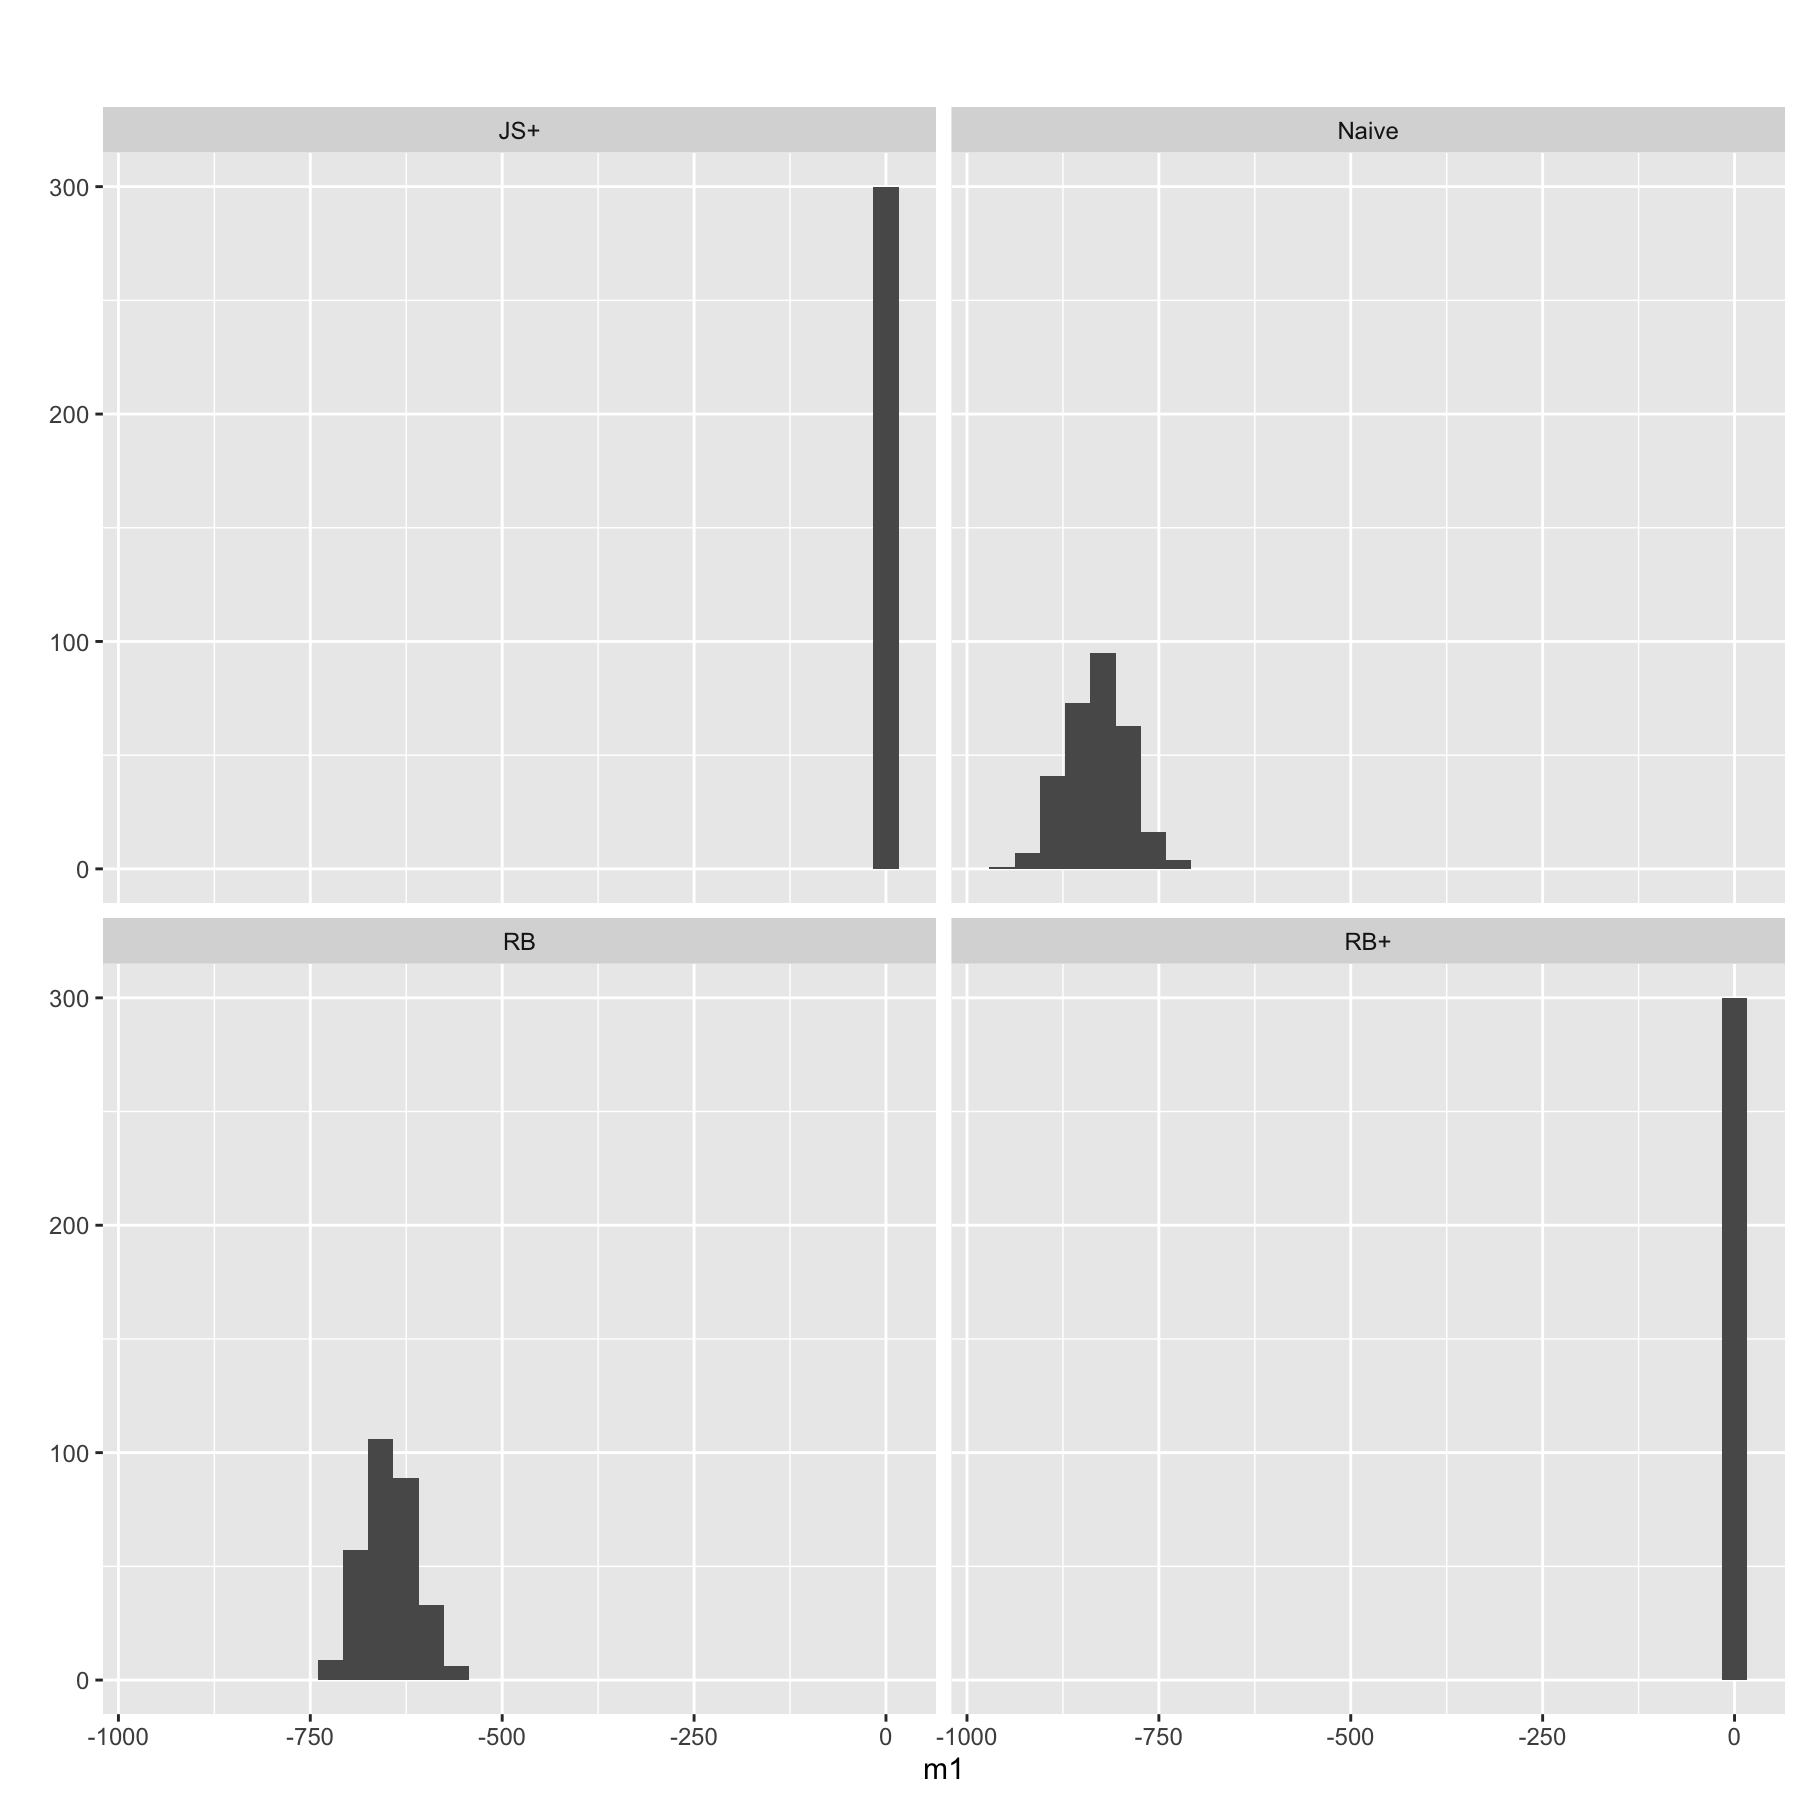

In [96]:
last_iteration <- readRDS("Outputs/last_iteration.R")

options(repr.plot.width = 15, repr.plot.height = 15)
last_iteration %>%
    filter(param == "m" & method %in% c("Naive", "JS+", "RB","RB+")) %>%
    ggplot() +
    geom_histogram(aes(x=X1)) +
    facet_wrap(~method) +
    labs(title = "", subtitle = "", x = "m1", y = "") +
    theme_grey(base_size = 18)

## Trace Plots of the BBVI Progress

We look as well at the progress of using the different flavors of BBVI at finding the target distributions. First, we generate the data and parameter initializations as follows:

In [49]:
set.seed(923)
d <- generate_mixture(100, c(0.4, 0.6), means=c(-2, 2), vars=c(1, 1))

prior_list = list(
    tausq = 25,
    sigmasq = 1
)

# Generate Random Starts
phi <- t(sapply(d, function(x){
        y <- runif(2)
        return(y/sum(y))
    }))

m <- c(1,-1)

ssq <- c(3,3)

params <- data.frame(
    param = c(paste0("z", 1:nrow(phi)),"m","ssq"),
    rbind(
        phi,
        m,
        ssq
    )
)

rownames(params) <- NULL

tail(params)


,param,X1,X2
,<chr>,<dbl>,<dbl>
97,z97,0.6827135,0.3172865
98,z98,0.4927582,0.5072418
99,z99,0.7497611,0.2502389
100,z100,0.1287460,0.8712540
101,m,1.0000000,-1.0000000
102,ssq,3.0000000,3.0000000


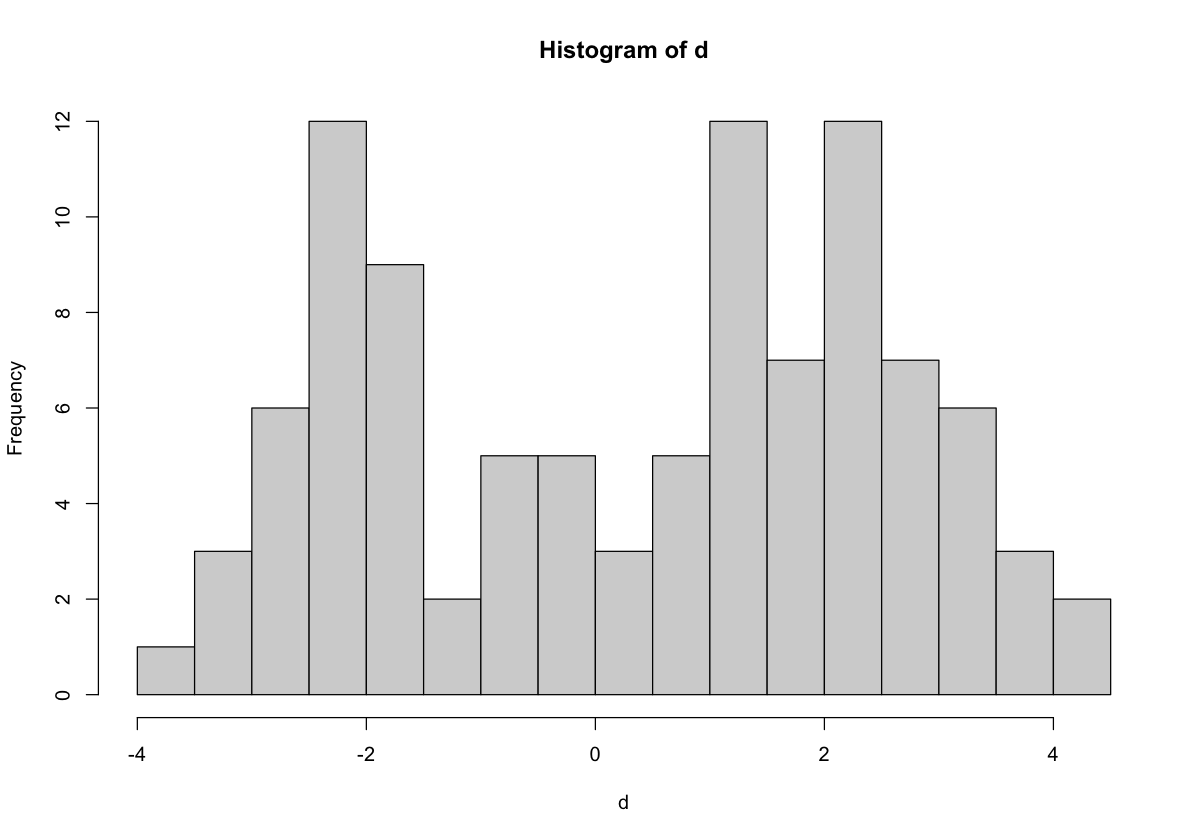

In [50]:
hist(d, breaks = 20)

### Naive

In [ ]:
trace.nav <- simplemix.bbvi(data=d, K=2, priors = prior_list, maxiter=5000, init=params, learn_rate = rate_adagrad(1e-2), mc_size=1000, method="Naive", verbose=TRUE)

### James-Stein Estimator

In [40]:
trace.jsp <- simplemix.bbvi(data=d, K=2, priors = prior_list, maxiter=300, init=params, learn_rate = rate_adagrad(1e-2), mc_size=1000, method="JS+", verbose=TRUE)

Doing Black Box Variational Inference With Method JS+

BBVI-JS+: Iteration 10 | Means at 0.0484629912247625, 0.0316596133742403

BBVI-JS+: Iteration 20 | Means at 0.0736330643176814, 0.051918577543258

BBVI-JS+: Iteration 30 | Means at 0.0887955296670028, 0.0697419011515428

BBVI-JS+: Iteration 40 | Means at 0.0946610651198695, 0.0833645011933707

BBVI-JS+: Iteration 50 | Means at 0.103634987386417, 0.092930949635303

BBVI-JS+: Iteration 60 | Means at 0.10965471909937, 0.100503893317139

BBVI-JS+: Iteration 70 | Means at 0.117175340114073, 0.107164048828002

BBVI-JS+: Iteration 80 | Means at 0.124258768167238, 0.113241380259072



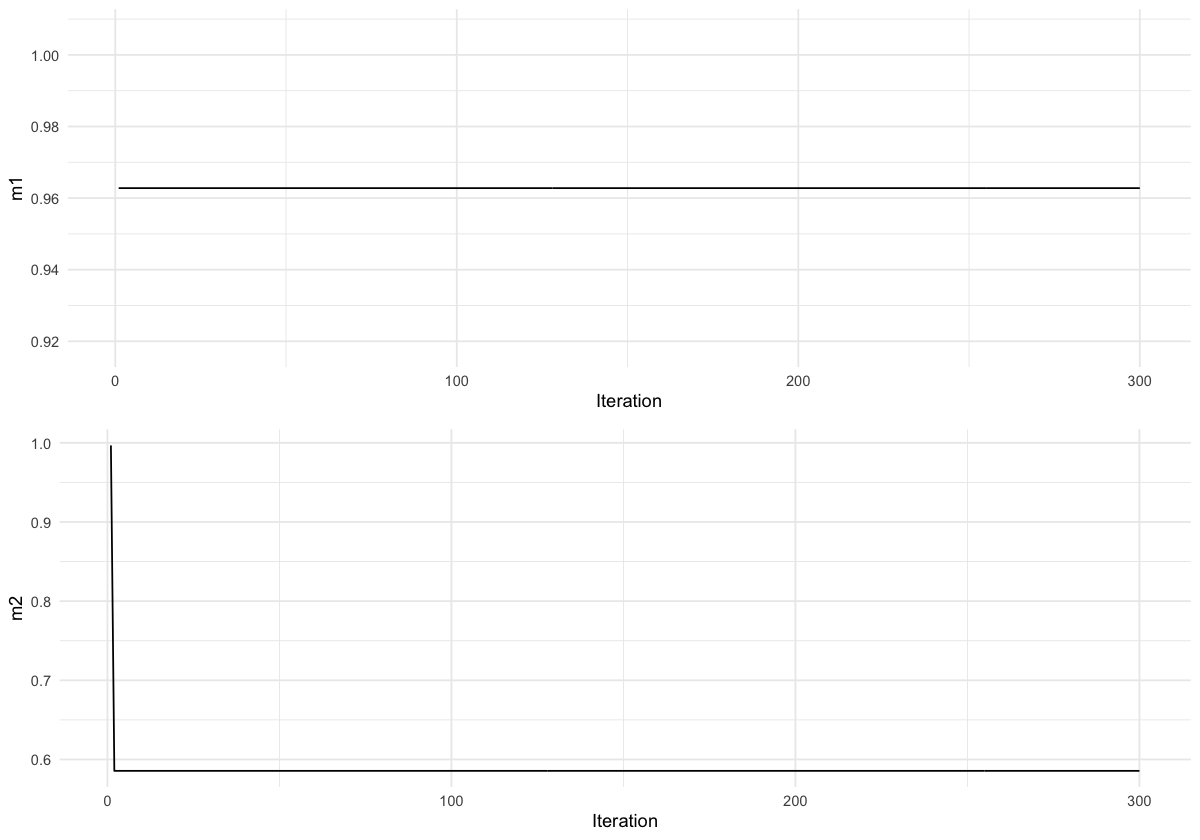

In [38]:
p1 <- trace.jsp %>%
    filter(param == "m" & iter <= 300) %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "m1") +
    theme_minimal()

p2 <- trace.jsp %>%
    filter(param == "m") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "m2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

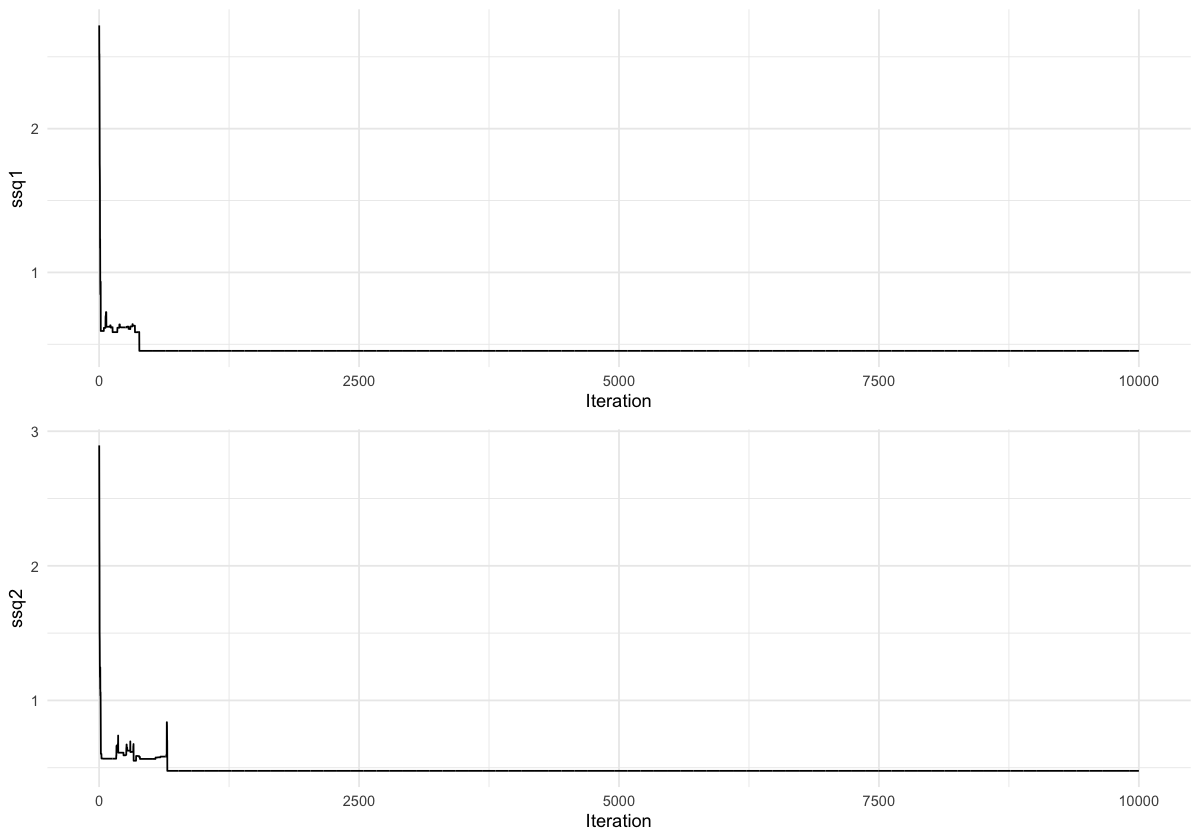

In [10]:
p1 <- trace.jsp %>%
    filter(param == "ssq") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq1") +
    theme_minimal()

p2 <- trace.jsp %>%
    filter(param == "ssq") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

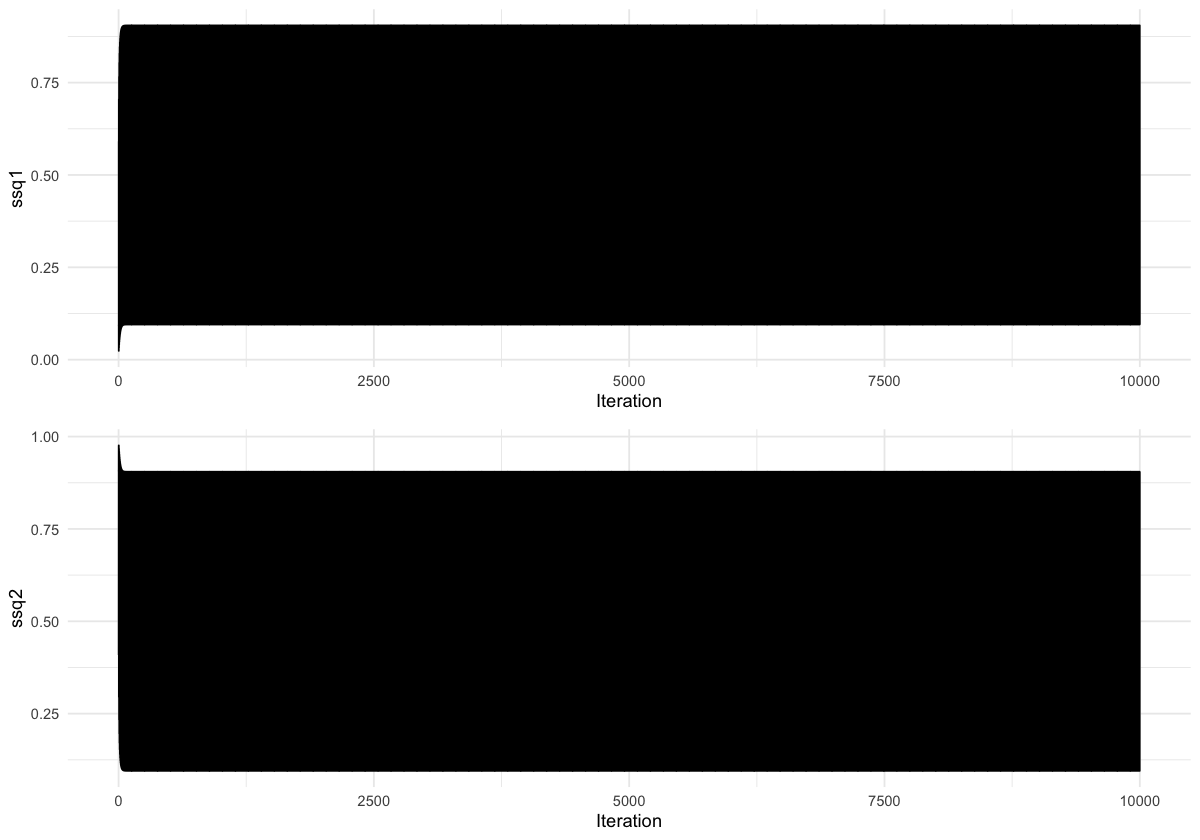

In [11]:
p1 <- trace.jsp %>%
    filter(param == "z3") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq1") +
    theme_minimal()

p2 <- trace.jsp %>%
    filter(param == "z3") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

In [12]:
# Final parameters
last_param <- trace.jsp %>%
    filter(iter == max(iter) & param %in% c("m","ssq"))

last_param

iter,time,param,X1,X2
<int>,<dbl>,<chr>,<dbl>,<dbl>
10000,-205.8103,m,1.0610299,1.1074981
10000,-205.8103,ssq,0.4543219,0.4766343


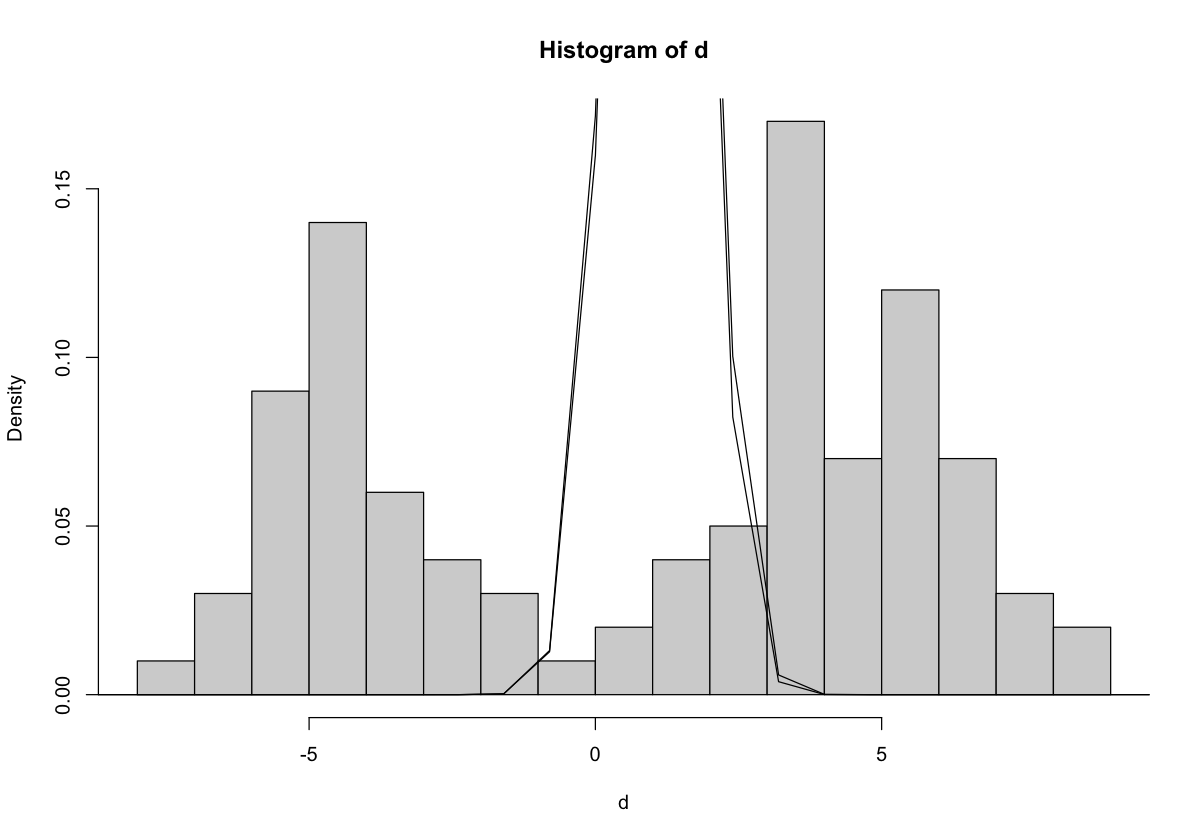

In [13]:
x <- seq(min(d), max(d), length = 100)
prob1 <- dnorm(x, mean = last_param$X1[1], sd = sqrt(last_param$X1[2]))

par(bg = "white")
hist(d, breaks = 20, probability = TRUE)
curve(dnorm(x, mean = last_param$X1[1], sd = sqrt(last_param$X1[2])), from=-40, to=40, add = TRUE)
curve(dnorm(x, mean = last_param$X2[1], sd = sqrt(last_param$X2[2])), from=-40, to=40, add = TRUE)

### Rao-Blackwellized

In [48]:
trace.rbl <- simplemix.bbvi(data=d, K=2, priors=prior_list, maxiter=1000, init=params, learn_rate = rate_adagrad(1e-1), mc_size=1000, method="RB", verbose=TRUE)

Doing Black Box Variational Inference With Method RB



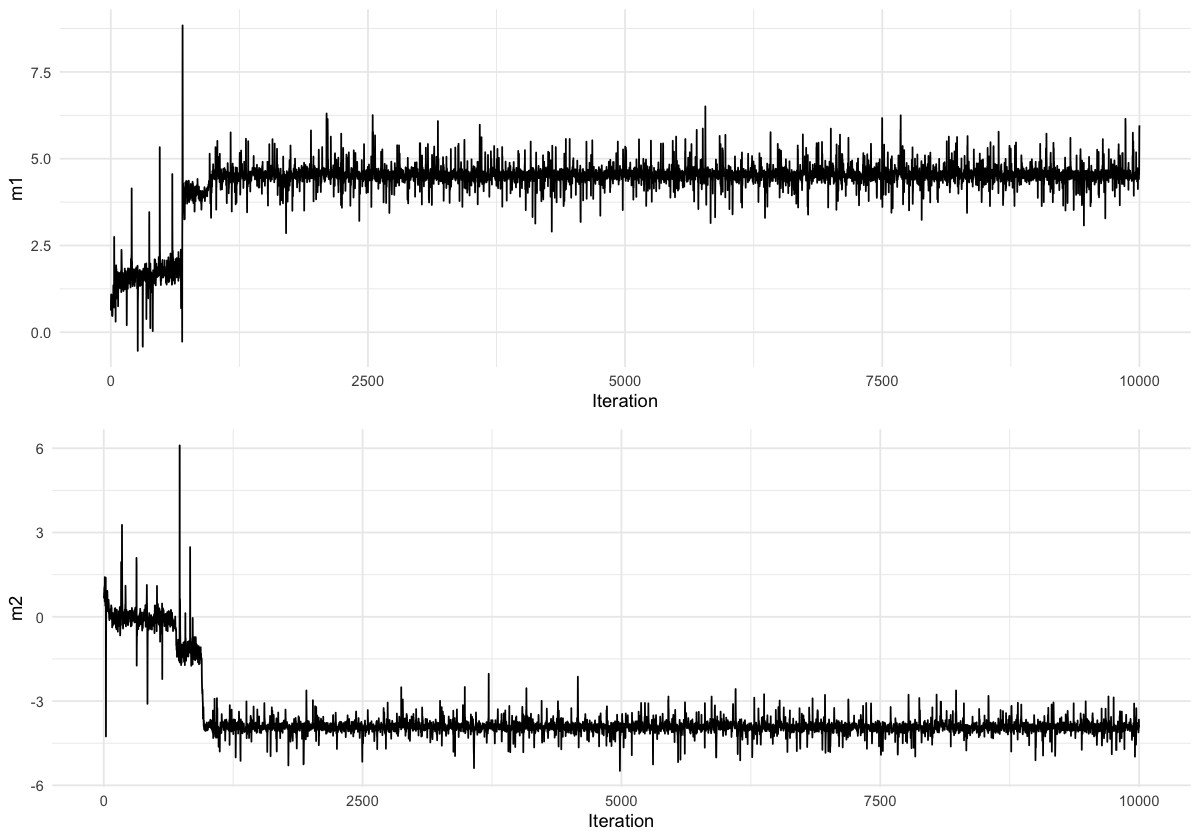

In [15]:
p1 <- trace.rbl %>%
    filter(param == "m") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "m1") +
    theme_minimal()

p2 <- trace.rbl %>%
    filter(param == "m") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "m2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

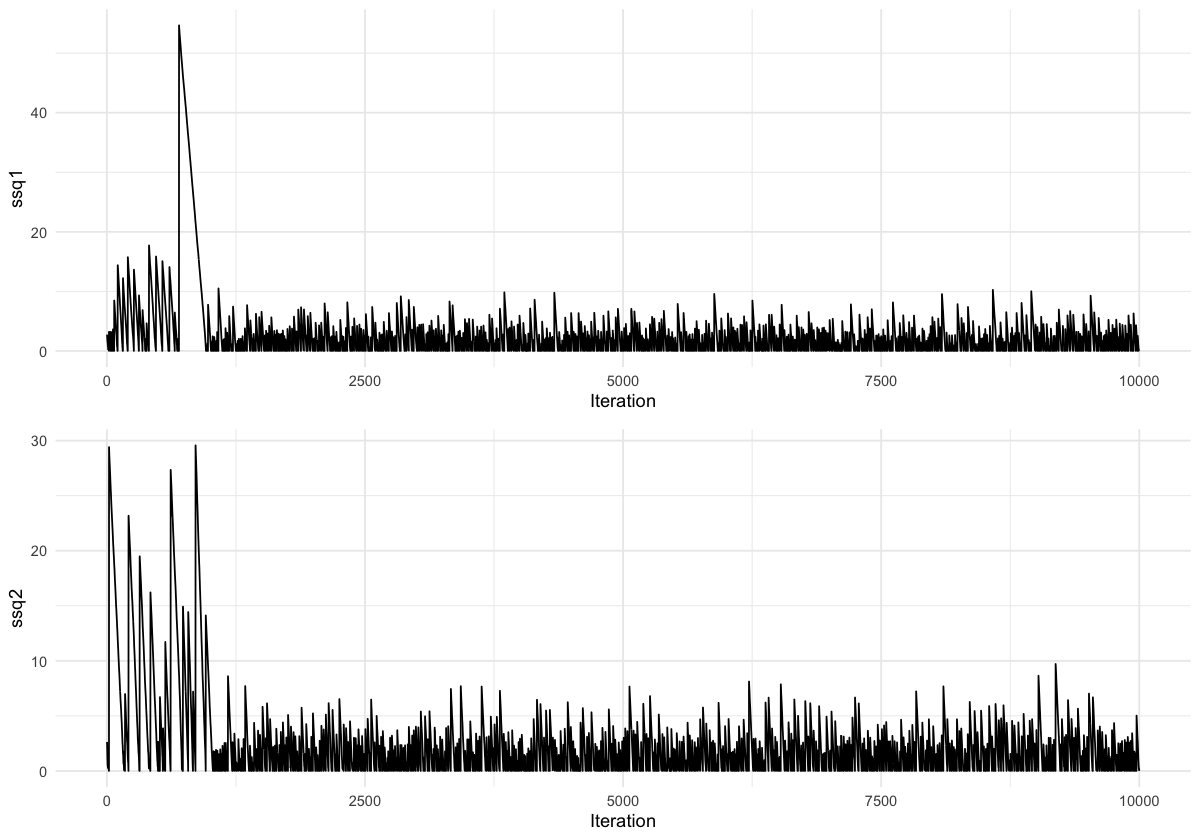

In [16]:
p1 <- trace.rbl %>%
    filter(param == "ssq") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq1") +
    theme_minimal()

p2 <- trace.rbl %>%
    filter(param == "ssq") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "ssq2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

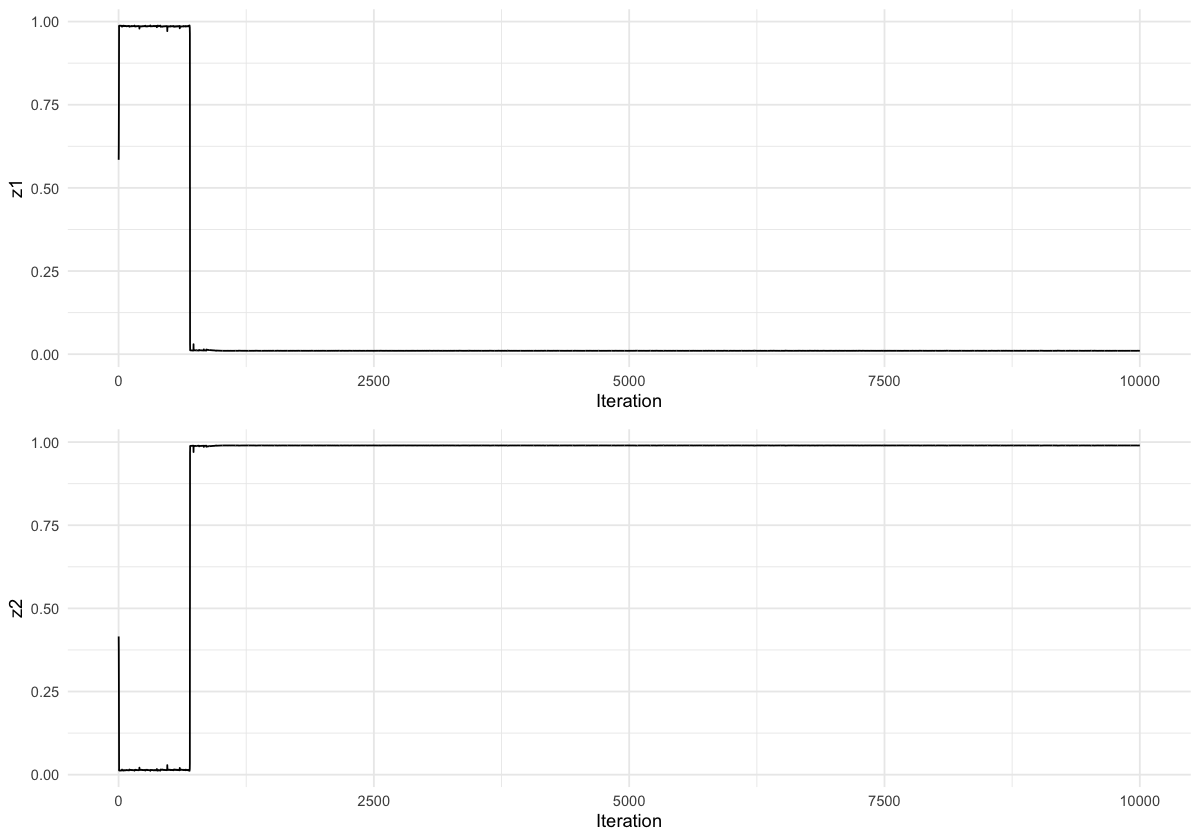

In [17]:
p1 <- trace.rbl %>%
    filter(param == "z1") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "z1") +
    theme_minimal()

p2 <- trace.rbl %>%
    filter(param == "z1") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "z2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

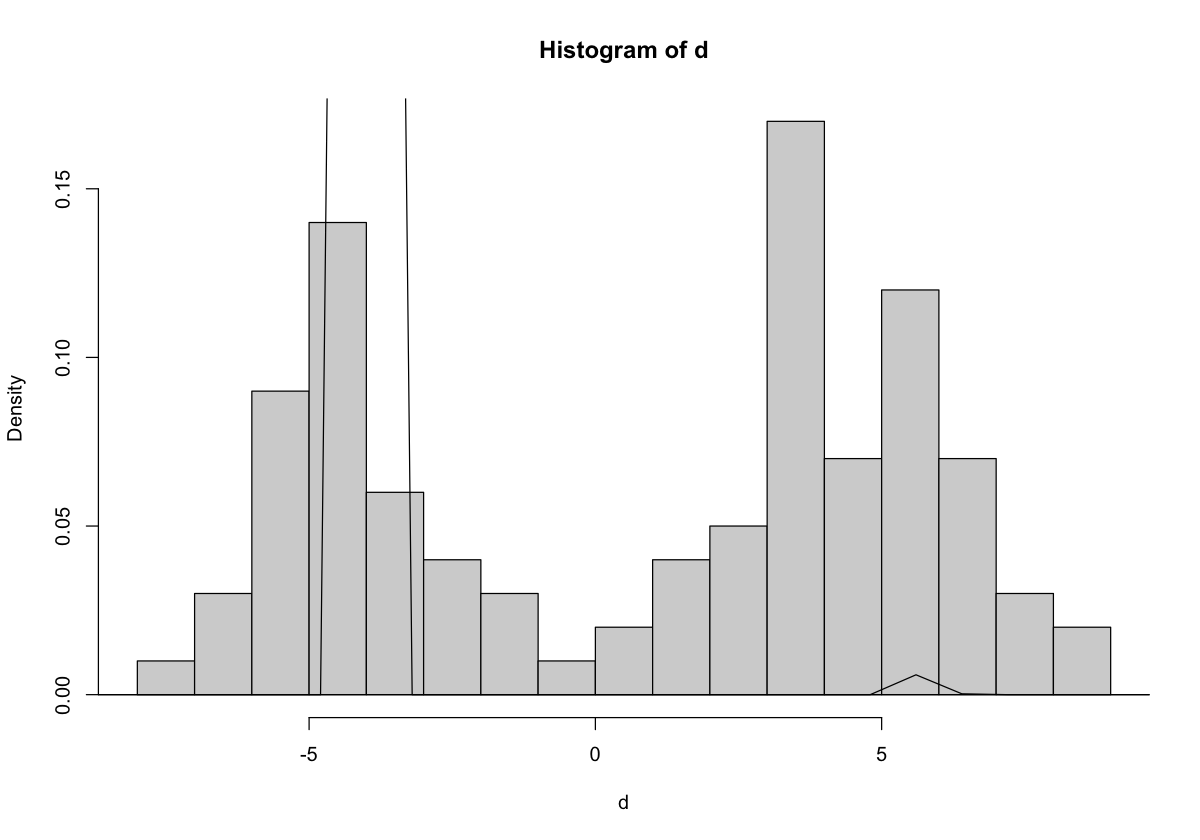

In [18]:
# Final parameters
last_param <- trace.rbl %>%
    filter(iter == max(iter) & param %in% c("m","ssq"))

x <- seq(min(d), max(d), length = 100)
prob1 <- dnorm(x, mean = last_param$X1[1], sd = sqrt(last_param$X1[2]))

par(bg = "white")
hist(d, breaks = 20, probability = TRUE)
curve(dnorm(x, mean = last_param$X1[1], sd = sqrt(last_param$X1[2])), from=-40, to=40, add = TRUE)
curve(dnorm(x, mean = last_param$X2[1], sd = sqrt(last_param$X2[2])), from=-40, to=40, add = TRUE)

### Rao Blackwellized With James-Stein Estimator

In [19]:
trace.rbp <- simplemix.bbvi(data=d, K=2, maxiter=5000, init=params, learn_rate = rate_adagrad(1e-3), mc_size=1000, method="RB+", verbose=TRUE)

Doing Black Box Variational Inference With Method RB+

BBVI-RB+: Iteration 10

BBVI-RB+: Iteration 20

BBVI-RB+: Iteration 30

BBVI-RB+: Iteration 40

BBVI-RB+: Iteration 50

BBVI-RB+: Iteration 60

BBVI-RB+: Iteration 70

BBVI-RB+: Iteration 80

BBVI-RB+: Iteration 90

BBVI-RB+: Iteration 100

BBVI-RB+: Iteration 110

BBVI-RB+: Iteration 120

BBVI-RB+: Iteration 130

BBVI-RB+: Iteration 140

BBVI-RB+: Iteration 150

BBVI-RB+: Iteration 160

BBVI-RB+: Iteration 170

BBVI-RB+: Iteration 180

BBVI-RB+: Iteration 190

BBVI-RB+: Iteration 200

BBVI-RB+: Iteration 210

BBVI-RB+: Iteration 220

BBVI-RB+: Iteration 230

BBVI-RB+: Iteration 240

BBVI-RB+: Iteration 250

BBVI-RB+: Iteration 260

BBVI-RB+: Iteration 270

BBVI-RB+: Iteration 280

BBVI-RB+: Iteration 290

BBVI-RB+: Iteration 300

BBVI-RB+: Iteration 310

BBVI-RB+: Iteration 320

BBVI-RB+: Iteration 330

BBVI-RB+: Iteration 340

BBVI-RB+: Iteration 350

BBVI-RB+: Iteration 360

BBVI-RB+: Iteration 370

BBVI-RB+: Iteration 380

BBVI

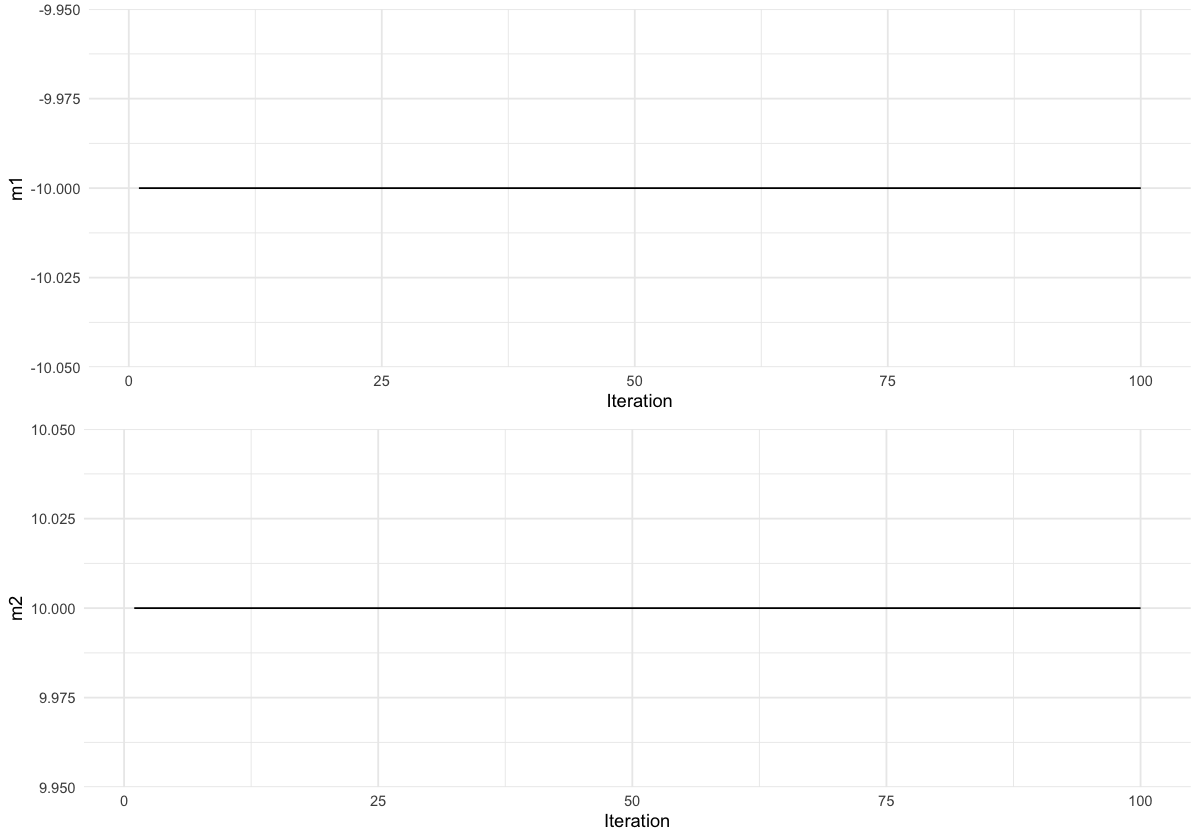

In [ ]:
p1 <- trace.rbp %>%
    filter(param == "m") %>%
    ggplot(aes(x = iter, y = X1)) +
    geom_line() +
    labs(x = "Iteration", y = "m1") +
    theme_minimal()

p2 <- trace.rbp %>%
    filter(param == "m") %>%
    ggplot(aes(x = iter, y = X2)) +
    geom_line() +
    labs(x = "Iteration", y = "m2") +
    theme_minimal()

grid.arrange(p1, p2, nrow = 2)

## Analysis of Fit Statistics Using the Log-Likelihood and DIC